In [2]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

from scipy import stats
import cv2
import numpy as np
import math
from os import makedirs
from torchvision.utils import save_image
import torch

In [3]:
def earthMoversDistance_calculation(true, fake, display=False):

    true_adjusted = true.reshape(64*28*28)
    fake_adjusted = fake.reshape(64*28*28)

    # Normalize true and fake
    true_adjusted = cv2.normalize(np.array(true_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    fake_adjusted = cv2.normalize(np.array(fake_adjusted), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    true_adjusted = np.array([elem[0] for elem in true_adjusted]).reshape(64*28*28)
    fake_adjusted = np.array([elem[0] for elem in fake_adjusted]).reshape(64*28*28)

    if display: print(true_adjusted[0:1])
    if display: print(fake_adjusted[0:1])
    
    # Get JSD
    emd = stats.wasserstein_distance(true_adjusted, fake_adjusted)

    # Remove inf values
    #emd_adjusted = [v for v in emd if not math.isnan(v) and not math.isinf(v)]

    return emd #stats.mean(emd_adjusted)

# output = jsd_calculation(true, fake, display=False)
# print(output)

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}
 
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [5]:
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model
 
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [6]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(8 * 8):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	g_model.save('results_baseline/model_%03d.h5' % (step+1))
	print('>Saved: %s and %s' % (filename1, filename2))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, emd_epochs):
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='c-real')
	pyplot.plot(d2_hist, label='c-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
 	# plot jsd
	pyplot.subplot(2, 1, 2)
	pyplot.plot(emd_epochs, label='emd')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('/content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/mnist_trainingLoss.png')
	pyplot.close()

In [7]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist, emd_epochs = list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		emd = earthMoversDistance_calculation(X_real, X_fake)
		emd_epochs.append(emd)
		# summarize loss on this batch
		print('>%d out of %d, c1=%.3f, c2=%.3f g=%.3f emd=%.3f' % (i+1, n_steps, c1_hist[-1], c2_hist[-1], g_loss, emd))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist, emd_epochs)
	#return (X_real, X_fake)

In [8]:
makedirs('results_baseline', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

11490434/11490434 [==============================] - 0s 0us/step
(6265, 28, 28, 1)
2/2 [==============================] - 0s 4ms/step
>1 out of 2400, c1=-1.585, c2=0.071 g=-0.756 emd=0.437
2/2 [==============================] - 0s 4ms/step
>2 out of 2400, c1=-6.200, c2=0.182 g=-1.806 emd=0.435
2/2 [==============================] - 0s 4ms/step
>3 out of 2400, c1=-9.435, c2=0.267 g=-2.908 emd=0.415
2/2 [==============================] - 0s 4ms/step
>4 out of 2400, c1=-11.788, c2=0.330 g=-3.868 emd=0.429
2/2 [==============================] - 0s 4ms/step
>5 out of 2400, c1=-13.657, c2=0.394 g=-4.636 emd=0.428
2/2 [==============================] - 0s 4ms/step
>6 out of 2400, c1=-15.321, c2=0.464 g=-5.515 emd=0.453
2/2 [==============================] - 0s 3ms/step
>7 out of 2400, c1=-16.878, c2=0.500 g=-6.575 emd=0.464
2/2 [==============================] - 0s 4ms/step
>8 out of 2400, c1=-18.618, c2=0.557 g=-7.803 emd=0.440
2/2 [==============================] - 0s 4ms/step
>9 out of 240

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0048.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0048.h5
2/2 [==============================] - 0s 4ms/step
>49 out of 2400, c1=-41.901, c2=-17.616 g=-24.990 emd=0.312
2/2 [==============================] - 0s 4ms/step
>50 out of 2400, c1=-42.559, c2=-18.825 g=-25.330 emd=0.313
2/2 [==============================] - 0s 4ms/step
>51 out of 2400, c1=-42.970, c2=-20.405 g=-25.590 emd=0.332
2/2 [==============================] - 0s 4ms/step
>52 out of 2400, c1=-43.598, c2=-21.564 g=-25.399 emd=0.310
2/2 [==============================] - 0s 4ms/step
>53 out of 2400, c1=-44.609, c2=-23.439 g=-26.019 emd=0.351
2/2 [==============================] - 0s 4ms/step
>54 out of 2400, c1=-44.364, c2=-24.282 g=-27.742 emd=0.322
2/2 [==============================] - 0s 4ms/step
>55 out of 2400, c1=-45.710, c2=-25.888 g=-27.876 emd=0.338
2/2 [==============================] 

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0096.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0096.h5
2/2 [==============================] - 0s 4ms/step
>97 out of 2400, c1=-74.344, c2=-62.219 g=-65.570 emd=0.329
2/2 [==============================] - 0s 4ms/step
>98 out of 2400, c1=-74.799, c2=-63.391 g=-67.072 emd=0.327
2/2 [==============================] - 0s 4ms/step
>99 out of 2400, c1=-75.932, c2=-63.735 g=-67.585 emd=0.345
2/2 [==============================] - 0s 4ms/step
>100 out of 2400, c1=-76.206, c2=-64.802 g=-68.355 emd=0.321
2/2 [==============================] - 0s 4ms/step
>101 out of 2400, c1=-76.872, c2=-65.336 g=-68.943 emd=0.330
2/2 [==============================] - 0s 4ms/step
>102 out of 2400, c1=-77.471, c2=-66.312 g=-69.738 emd=0.315
2/2 [==============================] - 0s 4ms/step
>103 out of 2400, c1=-78.930, c2=-66.740 g=-70.910 emd=0.322
2/2 [============================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0144.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0144.h5
2/2 [==============================] - 0s 4ms/step
>145 out of 2400, c1=-109.199, c2=-99.576 g=-104.193 emd=0.271
2/2 [==============================] - 0s 4ms/step
>146 out of 2400, c1=-110.147, c2=-100.477 g=-105.456 emd=0.273
2/2 [==============================] - 0s 4ms/step
>147 out of 2400, c1=-111.184, c2=-100.842 g=-106.248 emd=0.260
2/2 [==============================] - 0s 4ms/step
>148 out of 2400, c1=-111.870, c2=-102.141 g=-108.271 emd=0.277
2/2 [==============================] - 0s 4ms/step
>149 out of 2400, c1=-112.215, c2=-102.386 g=-107.584 emd=0.263
2/2 [==============================] - 0s 4ms/step
>150 out of 2400, c1=-113.106, c2=-103.829 g=-109.182 emd=0.260
2/2 [==============================] - 0s 4ms/step
>151 out of 2400, c1=-113.952, c2=-104.331 g=-111.099 emd=0.284
2/2 [=====

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0192.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0192.h5
2/2 [==============================] - 0s 4ms/step
>193 out of 2400, c1=-148.205, c2=-140.379 g=-152.281 emd=0.154
2/2 [==============================] - 0s 4ms/step
>194 out of 2400, c1=-148.843, c2=-140.391 g=-152.420 emd=0.163
2/2 [==============================] - 0s 4ms/step
>195 out of 2400, c1=-149.468, c2=-142.039 g=-154.204 emd=0.169
2/2 [==============================] - 0s 4ms/step
>196 out of 2400, c1=-150.513, c2=-142.543 g=-154.857 emd=0.162
2/2 [==============================] - 0s 4ms/step
>197 out of 2400, c1=-151.797, c2=-143.837 g=-156.408 emd=0.159
2/2 [==============================] - 0s 4ms/step
>198 out of 2400, c1=-152.549, c2=-144.445 g=-157.458 emd=0.159
2/2 [==============================] - 0s 4ms/step
>199 out of 2400, c1=-153.488, c2=-144.911 g=-157.969 emd=0.152
2/2 [====

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0240.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0240.h5
2/2 [==============================] - 0s 4ms/step
>241 out of 2400, c1=-189.703, c2=-183.820 g=-197.622 emd=0.111
2/2 [==============================] - 0s 4ms/step
>242 out of 2400, c1=-191.983, c2=-184.727 g=-198.811 emd=0.110
2/2 [==============================] - 0s 4ms/step
>243 out of 2400, c1=-192.438, c2=-185.492 g=-198.502 emd=0.105
2/2 [==============================] - 0s 4ms/step
>244 out of 2400, c1=-193.043, c2=-186.903 g=-200.180 emd=0.110
2/2 [==============================] - 0s 4ms/step
>245 out of 2400, c1=-193.658, c2=-186.505 g=-200.900 emd=0.106
2/2 [==============================] - 0s 4ms/step
>246 out of 2400, c1=-195.309, c2=-188.387 g=-202.553 emd=0.110
2/2 [==============================] - 0s 4ms/step
>247 out of 2400, c1=-196.158, c2=-187.851 g=-203.239 emd=0.105
2/2 [====

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0288.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0288.h5
2/2 [==============================] - 0s 3ms/step
>289 out of 2400, c1=-234.656, c2=-226.959 g=-242.686 emd=0.091
2/2 [==============================] - 0s 4ms/step
>290 out of 2400, c1=-235.916, c2=-229.848 g=-244.403 emd=0.096
2/2 [==============================] - 0s 4ms/step
>291 out of 2400, c1=-236.606, c2=-230.287 g=-244.691 emd=0.094
2/2 [==============================] - 0s 4ms/step
>292 out of 2400, c1=-237.634, c2=-232.005 g=-245.996 emd=0.100
2/2 [==============================] - 0s 4ms/step
>293 out of 2400, c1=-238.011, c2=-232.838 g=-247.384 emd=0.096
2/2 [==============================] - 0s 4ms/step
>294 out of 2400, c1=-240.097, c2=-233.379 g=-248.212 emd=0.092
2/2 [==============================] - 0s 4ms/step
>295 out of 2400, c1=-241.410, c2=-234.228 g=-249.166 emd=0.099
2/2 [====

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0336.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0336.h5
2/2 [==============================] - 0s 4ms/step
>337 out of 2400, c1=-272.985, c2=-265.435 g=-287.014 emd=0.085
2/2 [==============================] - 0s 4ms/step
>338 out of 2400, c1=-274.298, c2=-263.212 g=-288.163 emd=0.086
2/2 [==============================] - 0s 4ms/step
>339 out of 2400, c1=-271.616, c2=-254.585 g=-284.986 emd=0.071
2/2 [==============================] - 0s 4ms/step
>340 out of 2400, c1=-274.261, c2=-272.278 g=-290.294 emd=0.088
2/2 [==============================] - 0s 4ms/step
>341 out of 2400, c1=-274.393, c2=-258.153 g=-286.823 emd=0.073
2/2 [==============================] - 0s 4ms/step
>342 out of 2400, c1=-274.576, c2=-271.595 g=-290.470 emd=0.078
2/2 [==============================] - 0s 4ms/step
>343 out of 2400, c1=-276.673, c2=-269.313 g=-291.096 emd=0.080
2/2 [====

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0384.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0384.h5
2/2 [==============================] - 0s 4ms/step
>385 out of 2400, c1=-118.051, c2=75.919 g=-143.386 emd=0.043
2/2 [==============================] - 0s 4ms/step
>386 out of 2400, c1=-122.649, c2=73.337 g=-147.343 emd=0.038
2/2 [==============================] - 0s 4ms/step
>387 out of 2400, c1=-122.438, c2=71.648 g=-150.587 emd=0.043
2/2 [==============================] - 0s 4ms/step
>388 out of 2400, c1=-127.688, c2=70.905 g=-155.007 emd=0.043
2/2 [==============================] - 0s 4ms/step
>389 out of 2400, c1=-131.492, c2=68.139 g=-162.168 emd=0.048
2/2 [==============================] - 0s 4ms/step
>390 out of 2400, c1=-135.559, c2=64.038 g=-168.008 emd=0.044
2/2 [==============================] - 0s 4ms/step
>391 out of 2400, c1=-135.280, c2=63.795 g=-170.693 emd=0.054
2/2 [==================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0432.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0432.h5
2/2 [==============================] - 0s 4ms/step
>433 out of 2400, c1=-267.488, c2=-114.653 g=-69.878 emd=0.401
2/2 [==============================] - 0s 4ms/step
>434 out of 2400, c1=-271.066, c2=-129.103 g=-68.225 emd=0.414
2/2 [==============================] - 0s 4ms/step
>435 out of 2400, c1=-272.923, c2=-140.984 g=-64.215 emd=0.427
2/2 [==============================] - 0s 4ms/step
>436 out of 2400, c1=-276.181, c2=-155.466 g=-58.835 emd=0.445
2/2 [==============================] - 0s 4ms/step
>437 out of 2400, c1=-277.020, c2=-168.946 g=-51.029 emd=0.475
2/2 [==============================] - 0s 4ms/step
>438 out of 2400, c1=-282.931, c2=-179.116 g=-41.639 emd=0.483
2/2 [==============================] - 0s 4ms/step
>439 out of 2400, c1=-285.838, c2=-187.854 g=-23.260 emd=0.501
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0480.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0480.h5
2/2 [==============================] - 0s 4ms/step
>481 out of 2400, c1=-386.146, c2=-370.876 g=367.517 emd=0.692
2/2 [==============================] - 0s 4ms/step
>482 out of 2400, c1=-388.478, c2=-372.192 g=368.908 emd=0.710
2/2 [==============================] - 0s 4ms/step
>483 out of 2400, c1=-389.932, c2=-373.449 g=369.921 emd=0.718
2/2 [==============================] - 0s 4ms/step
>484 out of 2400, c1=-391.955, c2=-374.334 g=370.520 emd=0.723
2/2 [==============================] - 0s 4ms/step
>485 out of 2400, c1=-393.499, c2=-375.241 g=371.747 emd=0.729
2/2 [==============================] - 0s 4ms/step
>486 out of 2400, c1=-393.643, c2=-376.608 g=373.117 emd=0.743
2/2 [==============================] - 0s 4ms/step
>487 out of 2400, c1=-396.467, c2=-377.756 g=374.676 emd=0.758
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0528.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0528.h5
2/2 [==============================] - 0s 4ms/step
>529 out of 2400, c1=-453.800, c2=-426.541 g=427.019 emd=0.878
2/2 [==============================] - 0s 4ms/step
>530 out of 2400, c1=-455.065, c2=-427.765 g=428.211 emd=0.877
2/2 [==============================] - 0s 4ms/step
>531 out of 2400, c1=-455.485, c2=-428.915 g=429.383 emd=0.876
2/2 [==============================] - 0s 4ms/step
>532 out of 2400, c1=-458.563, c2=-430.102 g=430.630 emd=0.875
2/2 [==============================] - 0s 4ms/step
>533 out of 2400, c1=-459.767, c2=-431.289 g=431.834 emd=0.880
2/2 [==============================] - 0s 4ms/step
>534 out of 2400, c1=-459.651, c2=-432.473 g=433.021 emd=0.886
2/2 [==============================] - 0s 4ms/step
>535 out of 2400, c1=-461.353, c2=-433.670 g=434.174 emd=0.877
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0576.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0576.h5
2/2 [==============================] - 0s 4ms/step
>577 out of 2400, c1=-512.391, c2=-482.639 g=483.402 emd=0.861
2/2 [==============================] - 0s 4ms/step
>578 out of 2400, c1=-513.313, c2=-483.912 g=484.593 emd=0.862
2/2 [==============================] - 0s 4ms/step
>579 out of 2400, c1=-515.245, c2=-485.183 g=485.794 emd=0.861
2/2 [==============================] - 0s 4ms/step
>580 out of 2400, c1=-516.274, c2=-486.375 g=487.064 emd=0.871
2/2 [==============================] - 0s 4ms/step
>581 out of 2400, c1=-517.920, c2=-487.552 g=488.241 emd=0.864
2/2 [==============================] - 0s 4ms/step
>582 out of 2400, c1=-518.870, c2=-488.739 g=489.433 emd=0.866
2/2 [==============================] - 0s 4ms/step
>583 out of 2400, c1=-519.564, c2=-489.825 g=490.717 emd=0.866
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0624.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0624.h5
2/2 [==============================] - 0s 4ms/step
>625 out of 2400, c1=-564.896, c2=-524.742 g=528.325 emd=0.554
2/2 [==============================] - 0s 4ms/step
>626 out of 2400, c1=-567.258, c2=-528.161 g=531.151 emd=0.566
2/2 [==============================] - 0s 4ms/step
>627 out of 2400, c1=-569.139, c2=-530.398 g=533.124 emd=0.566
2/2 [==============================] - 0s 4ms/step
>628 out of 2400, c1=-570.997, c2=-533.228 g=535.511 emd=0.585
2/2 [==============================] - 0s 4ms/step
>629 out of 2400, c1=-572.439, c2=-535.596 g=537.725 emd=0.591
2/2 [==============================] - 0s 4ms/step
>630 out of 2400, c1=-574.266, c2=-538.106 g=539.793 emd=0.616
2/2 [==============================] - 0s 4ms/step
>631 out of 2400, c1=-575.346, c2=-539.661 g=541.314 emd=0.609
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0672.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0672.h5
2/2 [==============================] - 0s 4ms/step
>673 out of 2400, c1=-620.345, c2=-542.100 g=561.072 emd=0.512
2/2 [==============================] - 0s 4ms/step
>674 out of 2400, c1=-620.254, c2=-530.526 g=557.848 emd=0.488
2/2 [==============================] - 0s 4ms/step
>675 out of 2400, c1=-619.108, c2=-524.847 g=554.108 emd=0.491
2/2 [==============================] - 0s 4ms/step
>676 out of 2400, c1=-619.509, c2=-515.723 g=549.028 emd=0.479
2/2 [==============================] - 0s 4ms/step
>677 out of 2400, c1=-618.474, c2=-498.578 g=539.354 emd=0.444
2/2 [==============================] - 0s 4ms/step
>678 out of 2400, c1=-616.803, c2=-478.571 g=532.046 emd=0.429
2/2 [==============================] - 0s 4ms/step
>679 out of 2400, c1=-613.736, c2=-467.260 g=520.458 emd=0.414
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0720.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0720.h5
2/2 [==============================] - 0s 4ms/step
>721 out of 2400, c1=-607.709, c2=-494.013 g=520.726 emd=0.190
2/2 [==============================] - 0s 4ms/step
>722 out of 2400, c1=-607.376, c2=-494.060 g=519.102 emd=0.174
2/2 [==============================] - 0s 5ms/step
>723 out of 2400, c1=-605.702, c2=-499.186 g=518.379 emd=0.179
2/2 [==============================] - 0s 4ms/step
>724 out of 2400, c1=-607.379, c2=-497.315 g=518.053 emd=0.164
2/2 [==============================] - 0s 4ms/step
>725 out of 2400, c1=-605.158, c2=-502.029 g=516.081 emd=0.177
2/2 [==============================] - 0s 4ms/step
>726 out of 2400, c1=-604.592, c2=-507.924 g=519.139 emd=0.173
2/2 [==============================] - 0s 4ms/step
>727 out of 2400, c1=-605.740, c2=-513.284 g=524.999 emd=0.172
2/2 [===========

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0768.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0768.h5
2/2 [==============================] - 0s 4ms/step
>769 out of 2400, c1=-253.714, c2=1.696 g=-20.689 emd=0.037
2/2 [==============================] - 0s 4ms/step
>770 out of 2400, c1=-248.075, c2=-1.881 g=-11.766 emd=0.035
2/2 [==============================] - 0s 4ms/step
>771 out of 2400, c1=-245.154, c2=5.666 g=-9.014 emd=0.030
2/2 [==============================] - 0s 4ms/step
>772 out of 2400, c1=-248.693, c2=-1.795 g=-18.389 emd=0.031
2/2 [==============================] - 0s 4ms/step
>773 out of 2400, c1=-252.087, c2=-1.934 g=-25.567 emd=0.031
2/2 [==============================] - 0s 4ms/step
>774 out of 2400, c1=-245.017, c2=6.939 g=-29.968 emd=0.028
2/2 [==============================] - 0s 4ms/step
>775 out of 2400, c1=-250.778, c2=-5.683 g=-35.649 emd=0.032
2/2 [=============================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0816.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0816.h5
2/2 [==============================] - 0s 4ms/step
>817 out of 2400, c1=-311.724, c2=9.268 g=-233.961 emd=0.048
2/2 [==============================] - 0s 4ms/step
>818 out of 2400, c1=-309.840, c2=31.415 g=-236.015 emd=0.041
2/2 [==============================] - 0s 4ms/step
>819 out of 2400, c1=-319.898, c2=80.738 g=-220.296 emd=0.026
2/2 [==============================] - 0s 4ms/step
>820 out of 2400, c1=-309.106, c2=191.192 g=-210.795 emd=0.023
2/2 [==============================] - 0s 4ms/step
>821 out of 2400, c1=-323.539, c2=151.102 g=-212.525 emd=0.022
2/2 [==============================] - 0s 4ms/step
>822 out of 2400, c1=-315.834, c2=157.124 g=-196.280 emd=0.023
2/2 [==============================] - 0s 4ms/step
>823 out of 2400, c1=-306.535, c2=115.423 g=-217.937 emd=0.024
2/2 [===============

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0864.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0864.h5
2/2 [==============================] - 0s 4ms/step
>865 out of 2400, c1=-240.414, c2=149.535 g=-190.732 emd=0.013
2/2 [==============================] - 0s 4ms/step
>866 out of 2400, c1=-244.068, c2=97.666 g=-187.998 emd=0.015
2/2 [==============================] - 0s 4ms/step
>867 out of 2400, c1=-248.812, c2=151.019 g=-169.241 emd=0.014
2/2 [==============================] - 0s 4ms/step
>868 out of 2400, c1=-234.477, c2=174.295 g=-186.556 emd=0.017
2/2 [==============================] - 0s 4ms/step
>869 out of 2400, c1=-235.239, c2=180.171 g=-177.228 emd=0.012
2/2 [==============================] - 0s 4ms/step
>870 out of 2400, c1=-237.233, c2=171.472 g=-174.284 emd=0.019
2/2 [==============================] - 0s 4ms/step
>871 out of 2400, c1=-237.761, c2=162.316 g=-179.499 emd=0.011
2/2 [============

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0912.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0912.h5
2/2 [==============================] - 0s 4ms/step
>913 out of 2400, c1=-113.933, c2=83.711 g=-57.843 emd=0.016
2/2 [==============================] - 0s 4ms/step
>914 out of 2400, c1=-107.428, c2=67.713 g=-61.574 emd=0.006
2/2 [==============================] - 0s 3ms/step
>915 out of 2400, c1=-107.456, c2=76.588 g=-51.994 emd=0.011
2/2 [==============================] - 0s 5ms/step
>916 out of 2400, c1=-106.070, c2=52.242 g=-60.836 emd=0.006
2/2 [==============================] - 0s 4ms/step
>917 out of 2400, c1=-106.669, c2=66.813 g=-34.718 emd=0.020
2/2 [==============================] - 0s 4ms/step
>918 out of 2400, c1=-102.098, c2=64.886 g=-58.652 emd=0.006
2/2 [==============================] - 0s 4ms/step
>919 out of 2400, c1=-107.409, c2=52.685 g=-64.193 emd=0.009
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_0960.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_0960.h5
2/2 [==============================] - 0s 4ms/step
>961 out of 2400, c1=-63.659, c2=39.719 g=-9.191 emd=0.006
2/2 [==============================] - 0s 4ms/step
>962 out of 2400, c1=-62.315, c2=35.966 g=-8.009 emd=0.005
2/2 [==============================] - 0s 4ms/step
>963 out of 2400, c1=-69.752, c2=36.151 g=-6.824 emd=0.006
2/2 [==============================] - 0s 4ms/step
>964 out of 2400, c1=-71.569, c2=38.287 g=-5.016 emd=0.006
2/2 [==============================] - 0s 4ms/step
>965 out of 2400, c1=-62.916, c2=41.537 g=-8.847 emd=0.007
2/2 [==============================] - 0s 4ms/step
>966 out of 2400, c1=-65.777, c2=39.307 g=-12.369 emd=0.007
2/2 [==============================] - 0s 4ms/step
>967 out of 2400, c1=-67.760, c2=39.714 g=-8.400 emd=0.008
2/2 [==============================] - 0s 4

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1008.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1008.h5
2/2 [==============================] - 0s 4ms/step
>1009 out of 2400, c1=-60.402, c2=36.241 g=-17.633 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1010 out of 2400, c1=-63.488, c2=39.762 g=-16.764 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1011 out of 2400, c1=-60.722, c2=38.892 g=-13.823 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1012 out of 2400, c1=-60.607, c2=38.261 g=-17.949 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1013 out of 2400, c1=-59.795, c2=38.335 g=-16.736 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1014 out of 2400, c1=-62.481, c2=41.290 g=-19.343 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1015 out of 2400, c1=-60.415, c2=36.140 g=-15.023 emd=0.012
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1056.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1056.h5
2/2 [==============================] - 0s 4ms/step
>1057 out of 2400, c1=-68.132, c2=45.654 g=-21.316 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1058 out of 2400, c1=-68.873, c2=42.672 g=-22.451 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1059 out of 2400, c1=-69.941, c2=45.245 g=-17.254 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1060 out of 2400, c1=-65.608, c2=40.766 g=-19.096 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1061 out of 2400, c1=-66.160, c2=44.082 g=-22.204 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1062 out of 2400, c1=-65.884, c2=40.652 g=-21.920 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1063 out of 2400, c1=-68.440, c2=43.602 g=-19.802 emd=0.007
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1104.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1104.h5
2/2 [==============================] - 0s 4ms/step
>1105 out of 2400, c1=-78.863, c2=54.274 g=-26.386 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1106 out of 2400, c1=-77.644, c2=44.858 g=-25.103 emd=0.013
2/2 [==============================] - 0s 4ms/step
>1107 out of 2400, c1=-74.044, c2=51.576 g=-28.070 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1108 out of 2400, c1=-78.651, c2=50.752 g=-28.310 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1109 out of 2400, c1=-76.826, c2=49.650 g=-29.761 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1110 out of 2400, c1=-73.057, c2=52.949 g=-30.699 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1111 out of 2400, c1=-75.730, c2=51.427 g=-30.630 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1152.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1152.h5
2/2 [==============================] - 0s 4ms/step
>1153 out of 2400, c1=-87.987, c2=57.974 g=-31.524 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1154 out of 2400, c1=-86.398, c2=61.584 g=-28.821 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1155 out of 2400, c1=-85.716, c2=57.026 g=-29.304 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1156 out of 2400, c1=-88.307, c2=59.389 g=-31.496 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1157 out of 2400, c1=-90.357, c2=61.010 g=-33.689 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1158 out of 2400, c1=-90.316, c2=65.023 g=-40.305 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1159 out of 2400, c1=-87.405, c2=62.261 g=-34.701 emd=0.009
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1200.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1200.h5
2/2 [==============================] - 0s 4ms/step
>1201 out of 2400, c1=-83.715, c2=57.804 g=-34.255 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1202 out of 2400, c1=-85.743, c2=58.266 g=-35.814 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1203 out of 2400, c1=-84.176, c2=57.645 g=-36.495 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1204 out of 2400, c1=-89.439, c2=62.023 g=-40.898 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1205 out of 2400, c1=-88.667, c2=62.877 g=-40.126 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1206 out of 2400, c1=-89.139, c2=61.829 g=-36.658 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1207 out of 2400, c1=-90.687, c2=62.174 g=-41.473 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1248.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1248.h5
2/2 [==============================] - 0s 4ms/step
>1249 out of 2400, c1=-83.181, c2=58.556 g=-35.390 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1250 out of 2400, c1=-83.154, c2=57.180 g=-34.363 emd=0.011
2/2 [==============================] - 0s 4ms/step
>1251 out of 2400, c1=-82.970, c2=53.946 g=-18.353 emd=0.015
2/2 [==============================] - 0s 4ms/step
>1252 out of 2400, c1=-87.064, c2=60.822 g=-34.505 emd=0.007
2/2 [==============================] - 0s 5ms/step
>1253 out of 2400, c1=-87.073, c2=57.826 g=-30.947 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1254 out of 2400, c1=-80.641, c2=54.296 g=-35.160 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1255 out of 2400, c1=-82.881, c2=59.028 g=-34.311 emd=0.008
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1296.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1296.h5
2/2 [==============================] - 0s 4ms/step
>1297 out of 2400, c1=-86.359, c2=54.564 g=-32.177 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1298 out of 2400, c1=-84.956, c2=60.975 g=-38.212 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1299 out of 2400, c1=-87.680, c2=59.992 g=-34.480 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1300 out of 2400, c1=-85.403, c2=59.000 g=-30.400 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1301 out of 2400, c1=-82.939, c2=55.753 g=-28.627 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1302 out of 2400, c1=-85.463, c2=60.278 g=-39.197 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1303 out of 2400, c1=-85.536, c2=58.508 g=-35.480 emd=0.004
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1344.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1344.h5
2/2 [==============================] - 0s 4ms/step
>1345 out of 2400, c1=-82.487, c2=55.241 g=-29.594 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1346 out of 2400, c1=-82.850, c2=58.537 g=-30.406 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1347 out of 2400, c1=-84.831, c2=56.195 g=-29.204 emd=0.004
2/2 [==============================] - 0s 5ms/step
>1348 out of 2400, c1=-82.113, c2=58.531 g=-29.153 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1349 out of 2400, c1=-84.158, c2=59.677 g=-35.393 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1350 out of 2400, c1=-82.612, c2=60.123 g=-34.222 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1351 out of 2400, c1=-83.331, c2=58.403 g=-29.755 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1392.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1392.h5
2/2 [==============================] - 0s 4ms/step
>1393 out of 2400, c1=-78.550, c2=45.362 g=-13.585 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1394 out of 2400, c1=-77.414, c2=51.716 g=-25.828 emd=0.012
2/2 [==============================] - 0s 4ms/step
>1395 out of 2400, c1=-74.949, c2=51.702 g=-25.396 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1396 out of 2400, c1=-76.219, c2=52.294 g=-16.456 emd=0.014
2/2 [==============================] - 0s 4ms/step
>1397 out of 2400, c1=-79.506, c2=52.520 g=-28.173 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1398 out of 2400, c1=-78.858, c2=55.104 g=-30.425 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1399 out of 2400, c1=-75.734, c2=50.731 g=-22.457 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1440.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1440.h5
2/2 [==============================] - 0s 4ms/step
>1441 out of 2400, c1=-78.997, c2=52.467 g=-29.264 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1442 out of 2400, c1=-79.865, c2=53.654 g=-25.801 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1443 out of 2400, c1=-74.957, c2=51.022 g=-26.571 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1444 out of 2400, c1=-77.968, c2=54.936 g=-30.364 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1445 out of 2400, c1=-79.526, c2=55.991 g=-29.899 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1446 out of 2400, c1=-76.566, c2=54.183 g=-38.382 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1447 out of 2400, c1=-79.854, c2=55.237 g=-34.245 emd=0.004
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1488.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1488.h5
2/2 [==============================] - 0s 4ms/step
>1489 out of 2400, c1=-80.154, c2=55.338 g=-28.604 emd=0.013
2/2 [==============================] - 0s 4ms/step
>1490 out of 2400, c1=-81.186, c2=56.215 g=-37.402 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1491 out of 2400, c1=-80.384, c2=58.690 g=-31.955 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1492 out of 2400, c1=-81.260, c2=56.762 g=-32.931 emd=0.005
2/2 [==============================] - 0s 5ms/step
>1493 out of 2400, c1=-79.749, c2=53.150 g=-28.117 emd=0.011
2/2 [==============================] - 0s 4ms/step
>1494 out of 2400, c1=-80.840, c2=57.609 g=-25.249 emd=0.014
2/2 [==============================] - 0s 4ms/step
>1495 out of 2400, c1=-78.459, c2=56.337 g=-31.885 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1536.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1536.h5
2/2 [==============================] - 0s 4ms/step
>1537 out of 2400, c1=-81.761, c2=56.629 g=-31.527 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1538 out of 2400, c1=-79.682, c2=56.893 g=-34.672 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1539 out of 2400, c1=-82.144, c2=58.122 g=-36.499 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1540 out of 2400, c1=-81.738, c2=57.932 g=-35.675 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1541 out of 2400, c1=-79.298, c2=57.710 g=-31.878 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1542 out of 2400, c1=-81.554, c2=54.464 g=-21.279 emd=0.016
2/2 [==============================] - 0s 4ms/step
>1543 out of 2400, c1=-83.461, c2=56.837 g=-27.478 emd=0.012
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1584.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1584.h5
2/2 [==============================] - 0s 4ms/step
>1585 out of 2400, c1=-78.230, c2=55.780 g=-28.542 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1586 out of 2400, c1=-83.324, c2=55.090 g=-27.314 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1587 out of 2400, c1=-80.948, c2=54.221 g=-26.801 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1588 out of 2400, c1=-81.332, c2=53.834 g=-30.779 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1589 out of 2400, c1=-81.728, c2=54.124 g=-28.159 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1590 out of 2400, c1=-76.044, c2=51.351 g=-21.799 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1591 out of 2400, c1=-78.478, c2=51.747 g=-27.101 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1632.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1632.h5
2/2 [==============================] - 0s 4ms/step
>1633 out of 2400, c1=-81.775, c2=59.401 g=-29.210 emd=0.010
2/2 [==============================] - 0s 5ms/step
>1634 out of 2400, c1=-79.761, c2=57.049 g=-30.519 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1635 out of 2400, c1=-80.415, c2=54.088 g=-30.128 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1636 out of 2400, c1=-81.796, c2=56.744 g=-32.255 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1637 out of 2400, c1=-83.550, c2=57.774 g=-30.630 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1638 out of 2400, c1=-82.966, c2=58.154 g=-34.583 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1639 out of 2400, c1=-84.133, c2=55.450 g=-32.262 emd=0.008
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1680.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1680.h5
2/2 [==============================] - 0s 4ms/step
>1681 out of 2400, c1=-83.661, c2=61.032 g=-35.610 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1682 out of 2400, c1=-84.033, c2=58.780 g=-40.544 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1683 out of 2400, c1=-87.130, c2=61.878 g=-41.611 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1684 out of 2400, c1=-83.526, c2=60.242 g=-32.885 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1685 out of 2400, c1=-88.753, c2=57.832 g=-30.568 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1686 out of 2400, c1=-85.687, c2=58.258 g=-24.988 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1687 out of 2400, c1=-85.241, c2=58.149 g=-28.595 emd=0.012
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1728.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1728.h5
2/2 [==============================] - 0s 4ms/step
>1729 out of 2400, c1=-90.782, c2=62.019 g=-38.603 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1730 out of 2400, c1=-88.860, c2=64.144 g=-35.218 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1731 out of 2400, c1=-90.848, c2=63.669 g=-34.056 emd=0.008
2/2 [==============================] - 0s 4ms/step
>1732 out of 2400, c1=-87.077, c2=59.429 g=-31.817 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1733 out of 2400, c1=-89.159, c2=61.320 g=-31.135 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1734 out of 2400, c1=-87.358, c2=62.188 g=-39.733 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1735 out of 2400, c1=-89.208, c2=63.812 g=-40.151 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1776.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1776.h5
2/2 [==============================] - 0s 4ms/step
>1777 out of 2400, c1=-88.401, c2=61.292 g=-38.273 emd=0.015
2/2 [==============================] - 0s 4ms/step
>1778 out of 2400, c1=-90.685, c2=66.660 g=-44.661 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1779 out of 2400, c1=-91.152, c2=65.284 g=-40.093 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1780 out of 2400, c1=-92.197, c2=61.323 g=-28.270 emd=0.013
2/2 [==============================] - 0s 5ms/step
>1781 out of 2400, c1=-90.066, c2=65.198 g=-38.598 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1782 out of 2400, c1=-89.225, c2=62.446 g=-37.658 emd=0.005
2/2 [==============================] - 0s 5ms/step
>1783 out of 2400, c1=-93.259, c2=63.222 g=-28.859 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1824.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1824.h5
2/2 [==============================] - 0s 4ms/step
>1825 out of 2400, c1=-86.697, c2=60.585 g=-32.937 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1826 out of 2400, c1=-89.348, c2=56.918 g=-25.000 emd=0.009
2/2 [==============================] - 0s 4ms/step
>1827 out of 2400, c1=-88.530, c2=61.688 g=-37.812 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1828 out of 2400, c1=-84.931, c2=60.296 g=-40.347 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1829 out of 2400, c1=-87.838, c2=64.115 g=-39.961 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1830 out of 2400, c1=-89.810, c2=60.183 g=-39.930 emd=0.011
2/2 [==============================] - 0s 4ms/step
>1831 out of 2400, c1=-88.405, c2=63.548 g=-45.576 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1872.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1872.h5
2/2 [==============================] - 0s 4ms/step
>1873 out of 2400, c1=-88.506, c2=62.391 g=-37.862 emd=0.011
2/2 [==============================] - 0s 4ms/step
>1874 out of 2400, c1=-86.507, c2=60.746 g=-36.641 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1875 out of 2400, c1=-92.114, c2=60.181 g=-37.253 emd=0.007
2/2 [==============================] - 0s 4ms/step
>1876 out of 2400, c1=-87.115, c2=62.761 g=-42.570 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1877 out of 2400, c1=-85.954, c2=62.234 g=-40.849 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1878 out of 2400, c1=-88.888, c2=62.248 g=-40.381 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1879 out of 2400, c1=-89.311, c2=61.797 g=-38.330 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1920.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1920.h5
2/2 [==============================] - 0s 4ms/step
>1921 out of 2400, c1=-86.638, c2=63.007 g=-38.054 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1922 out of 2400, c1=-87.586, c2=61.775 g=-41.242 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1923 out of 2400, c1=-89.273, c2=63.989 g=-40.667 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1924 out of 2400, c1=-92.060, c2=67.207 g=-42.820 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1925 out of 2400, c1=-89.455, c2=64.363 g=-41.018 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1926 out of 2400, c1=-90.363, c2=64.591 g=-35.511 emd=0.004
2/2 [==============================] - 0s 4ms/step
>1927 out of 2400, c1=-91.569, c2=61.395 g=-41.806 emd=0.011
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_1968.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_1968.h5
2/2 [==============================] - 0s 4ms/step
>1969 out of 2400, c1=-91.891, c2=64.652 g=-42.704 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1970 out of 2400, c1=-90.477, c2=64.961 g=-43.773 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1971 out of 2400, c1=-90.697, c2=62.198 g=-42.520 emd=0.010
2/2 [==============================] - 0s 4ms/step
>1972 out of 2400, c1=-92.329, c2=64.662 g=-45.290 emd=0.006
2/2 [==============================] - 0s 4ms/step
>1973 out of 2400, c1=-85.504, c2=62.051 g=-35.625 emd=0.005
2/2 [==============================] - 0s 4ms/step
>1974 out of 2400, c1=-85.122, c2=60.953 g=-36.736 emd=0.014
2/2 [==============================] - 0s 4ms/step
>1975 out of 2400, c1=-87.257, c2=57.808 g=-38.981 emd=0.011
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2016.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2016.h5
2/2 [==============================] - 0s 5ms/step
>2017 out of 2400, c1=-90.152, c2=64.293 g=-44.388 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2018 out of 2400, c1=-90.884, c2=63.115 g=-49.022 emd=0.004
2/2 [==============================] - 0s 4ms/step
>2019 out of 2400, c1=-92.288, c2=67.185 g=-48.417 emd=0.008
2/2 [==============================] - 0s 4ms/step
>2020 out of 2400, c1=-93.198, c2=66.115 g=-48.375 emd=0.006
2/2 [==============================] - 0s 4ms/step
>2021 out of 2400, c1=-91.469, c2=67.851 g=-44.746 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2022 out of 2400, c1=-89.729, c2=63.557 g=-36.879 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2023 out of 2400, c1=-92.538, c2=65.462 g=-44.426 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2064.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2064.h5
2/2 [==============================] - 0s 4ms/step
>2065 out of 2400, c1=-85.898, c2=65.479 g=-44.556 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2066 out of 2400, c1=-89.087, c2=61.625 g=-41.169 emd=0.007
2/2 [==============================] - 0s 4ms/step
>2067 out of 2400, c1=-90.488, c2=63.849 g=-37.840 emd=0.004
2/2 [==============================] - 0s 4ms/step
>2068 out of 2400, c1=-89.460, c2=61.861 g=-34.576 emd=0.006
2/2 [==============================] - 0s 4ms/step
>2069 out of 2400, c1=-87.439, c2=58.266 g=-37.598 emd=0.009
2/2 [==============================] - 0s 4ms/step
>2070 out of 2400, c1=-88.761, c2=63.215 g=-39.079 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2071 out of 2400, c1=-84.939, c2=64.292 g=-41.393 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2112.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2112.h5
2/2 [==============================] - 0s 4ms/step
>2113 out of 2400, c1=-86.412, c2=62.150 g=-33.728 emd=0.015
2/2 [==============================] - 0s 4ms/step
>2114 out of 2400, c1=-84.096, c2=59.816 g=-43.227 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2115 out of 2400, c1=-88.724, c2=61.955 g=-43.237 emd=0.004
2/2 [==============================] - 0s 4ms/step
>2116 out of 2400, c1=-88.309, c2=65.299 g=-40.939 emd=0.007
2/2 [==============================] - 0s 4ms/step
>2117 out of 2400, c1=-88.740, c2=62.858 g=-44.235 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2118 out of 2400, c1=-87.775, c2=61.752 g=-39.142 emd=0.014
2/2 [==============================] - 0s 4ms/step
>2119 out of 2400, c1=-89.979, c2=59.937 g=-34.720 emd=0.007
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2160.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2160.h5
2/2 [==============================] - 0s 4ms/step
>2161 out of 2400, c1=-89.598, c2=63.535 g=-30.744 emd=0.017
2/2 [==============================] - 0s 4ms/step
>2162 out of 2400, c1=-82.915, c2=62.775 g=-41.948 emd=0.009
2/2 [==============================] - 0s 4ms/step
>2163 out of 2400, c1=-88.195, c2=63.140 g=-45.377 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2164 out of 2400, c1=-88.889, c2=61.562 g=-40.386 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2165 out of 2400, c1=-92.526, c2=62.761 g=-35.021 emd=0.006
2/2 [==============================] - 0s 4ms/step
>2166 out of 2400, c1=-86.904, c2=59.403 g=-38.485 emd=0.016
2/2 [==============================] - 0s 4ms/step
>2167 out of 2400, c1=-86.690, c2=62.009 g=-42.218 emd=0.005
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2208.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2208.h5
2/2 [==============================] - 0s 4ms/step
>2209 out of 2400, c1=-86.152, c2=63.515 g=-43.604 emd=0.007
2/2 [==============================] - 0s 4ms/step
>2210 out of 2400, c1=-85.926, c2=62.835 g=-42.004 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2211 out of 2400, c1=-91.793, c2=65.500 g=-44.994 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2212 out of 2400, c1=-92.682, c2=62.934 g=-40.112 emd=0.006
2/2 [==============================] - 0s 4ms/step
>2213 out of 2400, c1=-92.554, c2=58.664 g=-33.068 emd=0.014
2/2 [==============================] - 0s 4ms/step
>2214 out of 2400, c1=-88.963, c2=65.026 g=-44.263 emd=0.005
2/2 [==============================] - 0s 5ms/step
>2215 out of 2400, c1=-91.203, c2=64.654 g=-41.355 emd=0.006
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2256.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2256.h5
2/2 [==============================] - 0s 4ms/step
>2257 out of 2400, c1=-90.028, c2=66.822 g=-42.832 emd=0.007
2/2 [==============================] - 0s 4ms/step
>2258 out of 2400, c1=-91.747, c2=63.948 g=-40.786 emd=0.011
2/2 [==============================] - 0s 4ms/step
>2259 out of 2400, c1=-87.862, c2=68.201 g=-42.597 emd=0.012
2/2 [==============================] - 0s 4ms/step
>2260 out of 2400, c1=-95.306, c2=64.511 g=-48.531 emd=0.011
2/2 [==============================] - 0s 4ms/step
>2261 out of 2400, c1=-95.466, c2=68.343 g=-51.803 emd=0.007
2/2 [==============================] - 0s 4ms/step
>2262 out of 2400, c1=-89.482, c2=68.586 g=-52.742 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2263 out of 2400, c1=-96.737, c2=71.854 g=-47.825 emd=0.012
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2304.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2304.h5
2/2 [==============================] - 0s 4ms/step
>2305 out of 2400, c1=-95.128, c2=66.395 g=-43.647 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2306 out of 2400, c1=-94.004, c2=69.425 g=-46.316 emd=0.010
2/2 [==============================] - 0s 4ms/step
>2307 out of 2400, c1=-91.564, c2=69.786 g=-45.605 emd=0.012
2/2 [==============================] - 0s 4ms/step
>2308 out of 2400, c1=-91.516, c2=66.744 g=-42.561 emd=0.017
2/2 [==============================] - 0s 4ms/step
>2309 out of 2400, c1=-94.551, c2=71.463 g=-45.676 emd=0.009
2/2 [==============================] - 0s 4ms/step
>2310 out of 2400, c1=-90.151, c2=68.931 g=-47.978 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2311 out of 2400, c1=-96.682, c2=66.068 g=-44.451 emd=0.015
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2352.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2352.h5
2/2 [==============================] - 0s 5ms/step
>2353 out of 2400, c1=-97.844, c2=71.674 g=-55.042 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2354 out of 2400, c1=-97.940, c2=73.574 g=-48.430 emd=0.009
2/2 [==============================] - 0s 4ms/step
>2355 out of 2400, c1=-96.895, c2=71.099 g=-46.961 emd=0.010
2/2 [==============================] - 0s 4ms/step
>2356 out of 2400, c1=-97.078, c2=70.643 g=-51.908 emd=0.005
2/2 [==============================] - 0s 4ms/step
>2357 out of 2400, c1=-97.702, c2=70.204 g=-48.227 emd=0.006
2/2 [==============================] - 0s 4ms/step
>2358 out of 2400, c1=-94.735, c2=67.859 g=-50.758 emd=0.009
2/2 [==============================] - 0s 4ms/step
>2359 out of 2400, c1=-96.222, c2=68.102 g=-49.957 emd=0.009
2/2 [=========================

>Saved: /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/generated_plot_2400.png and /content/drive/MyDrive/Colab Notebooks/CSI5340_A4/output/mnist_wgan/model_2400.h5


In [ ]:
print("___________________________________________ Generator")
print(generator.summary())
print("___________________________________________ Critic")
print(critic.summary())

___________________________________________ Generator
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              319872    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 


In [ ]:
def save_Sample(sample, title):

  sample_subset = sample.reshape(64*28*28)
  sample_subset = cv2.normalize(np.array(sample_subset), None, alpha = 0.0, beta = 1.0, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  sample_subset = np.array([elem[0] for elem in sample_subset]).reshape(64,1,28,28)
  
  myX = list()
  for elem in sample_subset:
    elem = np.array(elem).reshape(1,28,28)
    myX.append(torch.Tensor(elem))

  save_image(myX, 'results_baseline/' +title+ '.png')

2/2 [==============================] - 0s 4ms/step


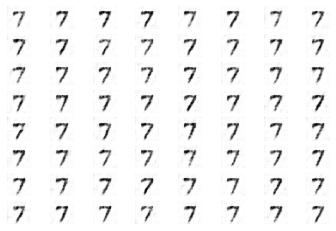

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot

# load model

model = load_model('results_baseline/model_336.h5')

X, _ = generate_fake_samples(model, latent_dim, 8*8)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot images
for i in range(8 * 8):
	# define subplot
	pyplot.subplot(8, 8, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
 

save_Sample(X, 'mnist_sample.png')